# PyTorch Model on Dummy Dataset (v5)

#### Chess Board Object Detection

#### CIS 520, Spring 2019

This notebook is written to run on [Google Colab](https://colab.research.google.com/notebook). 

----


In [1]:
# # Check out available CPU and GPU memory
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU

def print_CPU_GPU_info(GPUs):
    process = psutil.Process(os.getpid())
    print(f"\nCPU \tRAM Free: {humanize.naturalsize(psutil.virtual_memory().available)}"
          f"    | Proc size: {humanize.naturalsize(process.memory_info().rss)}")
    if GPUs[0]: 
        for i,gpu in enumerate(GPUs):
            print(f"GPU {i} \tRAM Free: {gpu.memoryFree/1000:.3f} GB  "
                  f"| Used: {gpu.memoryUsed/1000:.3f} GB"
                  f"\t| Utilization: {gpu.memoryUtil*100:3.0f}% | "
                  f"Total Memory: {gpu.memoryTotal/1000:.3f} GB")
    else: print(f"Not on a GPU")


In [2]:
print_CPU_GPU_info(GPU.getGPUs())


CPU 	RAM Free: 12.7 GB    | Proc size: 142.2 MB
GPU 0 	RAM Free: 11.441 GB  | Used: 0.000 GB	| Utilization:   0% | Total Memory: 11.441 GB


In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) { return false; }
// disable scrollable cells

<IPython.core.display.Javascript object>

In [0]:
# # ! rm -rf pytorch_general
# # ! rm pytorch_general
# # ! rm -rf images
# # ! rm -rf piece_images
# ! rm -rf chess-ray-vision
# ! rm -rf utils

In [5]:
! git clone https://github.com/samryan18/chess-ray-vision
! mv chess-ray-vision/clean_notebooks/* .


#NOTE this next line will download 2+ GB of data
#Do not run locally unless your comp can take that kinda heat
! git clone https://github.com/mukundv7/crvdataset 
! mkdir train_full
! mv crvdataset/chess-positions/train-full/* train_full/

fatal: destination path 'chess-ray-vision' already exists and is not an empty directory.
mv: cannot stat 'chess-ray-vision/clean_notebooks/*': No such file or directory
fatal: destination path 'crvdataset' already exists and is not an empty directory.
mkdir: cannot create directory ‘train_full’: File exists
mv: cannot stat 'crvdataset/chess-positions/train-full/*': No such file or directory


# Setup Stuff

In [6]:
# Pytorch Colab Setup
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'
!pip3 install https://download.pytorch.org/whl/cu100/torch-1.0.1-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision
  
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [7]:
## Required packages (Install in Colab)
!pip install tensorflow
!pip install scipy
!pip install numpy
!pip install Pillow
!pip install image


In [8]:
%matplotlib inline

####################################################
# CODE IMPORTS

from pytorch_general.pytorch_helper import imshow
from pytorch_general.tensorboard_helper import Logger
from utils.data_loading_utils import (onehot_from_fen, fen_from_onehot, 
                                     fen_from_64, fen_from_filename, 
                                     process_image)
from utils.draw_chess_boards import DrawChessPosition

####################################################
# EXTERNAL IMPORTS

import torchvision
import torch 
import torch.nn as nn
import torchvision.datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import numpy as np;
from torch.utils.data import Dataset, DataLoader
import time, datetime
from tqdm import tqdm
from torchsummary import summary

from random import randint

from PIL import Image
from pathlib import Path
from random import shuffle
import os


import glob

import torch.optim as optim
device =torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [9]:
fen = '4kN1N-bbbbbbbb-QQ3B2-R1n1b3-8-8-ppqKbKbk-8'
class_prob = onehot_from_fen(fen)

print(f"Original: \t{fen}")
print(f"Reconstructed:  {fen_from_onehot(class_prob)}")

Original: 	4kN1N-bbbbbbbb-QQ3B2-R1n1b3-8-8-ppqKbKbk-8
Reconstructed:  4kN1N-bbbbbbbb-QQ3B2-R1n1b3-8-8-ppqKbKbk-8


In [0]:
class CustomChessDataset(Dataset):
    """Chess dataset"""

    def __init__(self, 
                 transform=None,
                 root='train_full',
                 train_size = 10000,
                 test_size = 3000,
                 downsample_size = 200,
                 train=True):

        self._train = train
        self.downsample_size = downsample_size
            
        self.root = root
        self.pathlist = list(Path(self.root).glob('**/*.jpeg'))
        self.n_files = len(self.pathlist)
        
        self.train_size = train_size
        self.test_size = test_size

        self.train = glob.glob(f"{root}/*.jpeg")
        self.test = glob.glob(f"{root}/*.jpeg")

        shuffle(self.train)
        shuffle(self.test)

        self.train = self.train[:self.train_size]
        self.test = self.test[:self.test_size]


    def __len__(self):
        return self.train_size

    def __getitem__(self, idx):
        img = self.train[idx]
        label = onehot_from_fen(fen_from_filename(img))
        img_as_img, original_img = process_image(img, 
                                                 downsample_size = self.downsample_size)

        return ((torch.from_numpy(img_as_img).float()), 
                label,
                original_img)

In [0]:
# BATCH_SIZE needs to be small ish bc bigger models will scale 
# memory usage exponentially
BATCH_SIZE=10 
downsample_size=200
transform = transforms.Compose([transforms.Resize(downsample_size)])

train_dataset = CustomChessDataset(root='train_full/', train=True, 
                                   downsample_size=downsample_size)
test_dataset = CustomChessDataset(root='train_full/', train=False, 
                                  downsample_size=downsample_size)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True)

In [0]:
def train_model(model: nn.Module, 
                log_dir: str,
                train_loader: torch.utils.data.DataLoader,
                criterion: torch.nn.modules.Module,
                optimizer: torch.optim.Optimizer,
                num_epochs: int=1,
                log_freq: int=25,
                print_guess=False,
                print_guess_freq=50) -> nn.Module:
    
    # Create Logging Directory for Tensorboard
    now = time.mktime(datetime.datetime.now().timetuple()) - 1550000000
    log_dir = f'{log_dir} ({now})/'
    logger = Logger(log_dir)
    print(f'Training model. Logging to: "{log_dir}"\n')

    model = model.to(device) # Send model to GPU if possible
    model.train() # Set model to training mode

    total_step = len(train_loader)
    for epoch in range(num_epochs):
        if print_guess: print(f'Epoch {epoch}')
        running_loss = 0
        
        # Tqdm will create a progress bar
        with tqdm(len(train_loader), 
                  desc=f'Epoch {epoch}', 
                  unit=' minibatches',
                  disable=(print_guess)) as pbar:
            
            # Iterate through minibatches
            for step, (images, labels, original_imgs) in enumerate(train_loader):

                images, labels = images.to(device), labels.long().to(device)

                output = model(images).to(device)
                _,class_labels = torch.max(labels,2) 
                _, argmax = torch.max(output, 2)

                accuracy = float((class_labels == 
                                  argmax.squeeze()).float().mean().cpu())

                loss = criterion(output.reshape(10*64,13).float(),
                                 class_labels.reshape(10*64))

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()


                running_loss += float(loss.item())
                
                pbar.set_postfix(training_accuracy=accuracy, refresh=True)
                pbar.update(step)
                
                if step % log_freq == 0:
                    overall_step = epoch*total_step + step

                    # 1. Log scalar values (scalar summary)
                    info = { 'loss': loss.item(), 'accuracy': accuracy }

                    for key, value in info.items():
                        logger.scalar_summary(key, value, overall_step)

                    # 2. Log values and gradients of the parameters
                    # (histogram summary)
                    for key, value in model.named_parameters():
                        key = key.replace('.', '/')
                        logger.histo_summary(key, 
                                             value.data.cpu().numpy(), 
                                             overall_step)
                        try:
                            logger.histo_summary(key+'/grad', 
                                                 value.grad.data.cpu().numpy(),
                                                 overall_step)
                        except (AttributeError):
                            # During transfer learning some of the variables 
                            # don't have grads
                            pass
    
                if print_guess and step % print_guess_freq == 0:

                    overall_step = epoch*total_step + step
                    print(f"\n{60*'-'}\nBatch Number: {overall_step}")
                    print(f"Example training point:")
                    print(f"Actual: {fen_from_64(class_labels.cpu()[0])}")
                    print(f"Guess: {fen_from_64(argmax.cpu()[0])}")
                    print(f"Example Accuracy: {float((class_labels[0] == argmax[0]).float().mean().cpu())}")
                    
                    renderer = DrawChessPosition(delimiter='-')
                    board_actual = renderer.draw(fen_from_64(class_labels.cpu()[0]))
                    board_guess = renderer.draw(fen_from_64(argmax.cpu()[0]))
                    renderer.show_side_by_side(board1= original_imgs[0],
                                               board2=board_guess, 
                                               board1_title='Actual',
                                               board2_title='Prediction (Re'
                                                            'ndered to image)')
        print(f"{epoch}: Training loss: {running_loss/len(train_loader)}")
        print(f"{epoch}: Training accuracy: {accuracy}")
 
    return model



def test_model(model, criterion, test_loader) -> float:
    
    '''
    TODO: REWRITE THIS
    '''
    model = model.to(device)
    correct = 0
    total = 0
    accuracies = []
    losses = []
    total_step = len(test_loader)
    with torch.no_grad():
        for i in range(total_step):
            for  images, labels in test_loader:
                images, labels = images.to(device), labels.long().to(device)
                _,class_labels = torch.max(labels,1) 

                output = model(images).to(device)
                loss = criterion(output, class_labels)
                losses.append(float(loss.item()))


                # Compute accuracy
                _, argmax = torch.max(output, 1)
                accuracy = float((class_labels == argmax.squeeze()).float().mean().cpu())
                accuracies.append(accuracy)
                
    print(f'Accuracy of the network on test images: {np.average(accuracies)}')
    print(f'Avg. Loss of the network on test images: {np.average(losses)}')

    return np.average(accuracies)

# Models

In [0]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1) 

class SimpleCNN(torch.nn.Module):
    def __init__(self, batch_size):
        super(SimpleCNN, self).__init__()
        self.name = 'SimpleCNN'
        self.batch_size=batch_size
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1),
            nn.LeakyReLU(negative_slope=0.1))
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1),
            nn.ReLU())
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1),
            nn.ReLU())
        self.flatten = Flatten()
        self.fc1 = nn.Sequential(
            nn.Linear(32*19*19, 256),
            nn.ReLU(),
            nn.Dropout(p = 0.1))
        self.fc2 = nn.Sequential(
            nn.Linear(256, 13))

    def forward(self, x):
        x = x.reshape(self.batch_size*64,3,25,25)

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        x = self.flatten(x)
        
        x = self.fc1(x)
        x = self.fc2(x)
#         print(f'xsize: {x.size()}')
        x = x.reshape(self.batch_size,64,13)

        return(x)
    
class BiggerCNN(torch.nn.Module):
    def __init__(self, batch_size):
        super(BiggerCNN, self).__init__()
        self.name = 'BiggerCNN'
        self.batch_size=batch_size
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1),
            nn.LeakyReLU(negative_slope=0.1))
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU())
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU())
        self.flatten = Flatten()
        self.fc1 = nn.Sequential(
            nn.Linear(64*19*19, 512),
            nn.ReLU(),
            nn.Dropout(p = 0.1))
        self.fc2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(p = 0.1))
        self.fc3 = nn.Sequential(
            nn.Linear(256, 13))

    def forward(self, x):
        x = x.reshape(self.batch_size*64,3,25,25)

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        x = self.flatten(x)
        
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)

#         print(f'xsize: {x.size()}')
        x = x.reshape(self.batch_size,64,13)

        return(x)
    
# class BatchNormBiggerCNN(torch.nn.Module):
#     def __init__(self, batch_size):
#         super(BatchNormBiggerCNN, self).__init__()
#         self.name = 'BatchNormBiggerCNN'
#         self.batch_size=batch_size
#         self.conv1 = nn.Sequential(
#             nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1),
#             nn.BatchNorm2d(64),
#             nn.LeakyReLU(negative_slope=0.1),
#             nn.Dropout(p = 0.1))
#         self.conv2 = nn.Sequential(
#             nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(),
#             nn.Dropout(p = 0.1))
#         self.conv3 = nn.Sequential(
#             nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
#             nn.ReLU())
#         self.flatten = Flatten()
#         self.fc1 = nn.Sequential(
#             nn.Linear(64*19*19, 512),
#             nn.ReLU(),
#             nn.Dropout(p = 0.1))
#         self.fc2 = nn.Sequential(
#             nn.Linear(512, 256),
#             nn.ReLU(),
#             nn.Dropout(p = 0.1))
#         self.fc3 = nn.Sequential(
#             nn.Linear(256, 13))

#     def forward(self, x):
#         x = x.reshape(self.batch_size*64,3,25,25)

#         x = self.conv1(x)
#         x = self.conv2(x)
#         x = self.conv3(x)
        
#         x = self.flatten(x)
        
#         x = self.fc1(x)
#         x = self.fc2(x)
#         x = self.fc3(x)

# #         print(f'xsize: {x.size()}')
#         x = x.reshape(self.batch_size,64,13)

#         return(x)

# Run it...

In [14]:
LOG_DIR = './logs'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

!if [ -f ngrok ] ; then echo "Ngrok already installed" ; else wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip > /dev/null 2>&1 && unzip ngrok-stable-linux-amd64.zip > /dev/null 2>&1 ; fi

get_ipython().system_raw('./ngrok http 6006 &')

! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print('Tensorboard Link: ' +str(json.load(sys.stdin)['tunnels'][0]['public_url']))"

Ngrok already installed
Tensorboard Link: https://3eaa94da.ngrok.io


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 23, 23]           1,792
         LeakyReLU-2           [-1, 64, 23, 23]               0
            Conv2d-3           [-1, 64, 21, 21]          36,928
              ReLU-4           [-1, 64, 21, 21]               0
            Conv2d-5           [-1, 64, 19, 19]          36,928
              ReLU-6           [-1, 64, 19, 19]               0
           Flatten-7                [-1, 23104]               0
            Linear-8                  [-1, 512]      11,829,760
              ReLU-9                  [-1, 512]               0
          Dropout-10                  [-1, 512]               0
           Linear-11                  [-1, 256]         131,328
             ReLU-12                  [-1, 256]               0
          Dropout-13                  [-1, 256]               0
           Linear-14                   

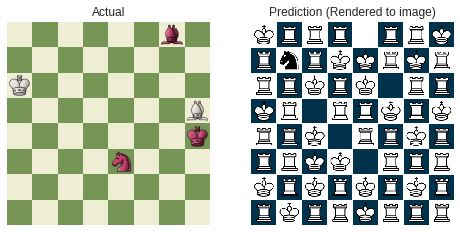


------------------------------------------------------------
Batch Number: 50
Example training point:
Actual: r7-1K6-4p3-7k-8-8-2p5-2r5
Guess: 8-8-8-8-8-8-8-8
Example Accuracy: 0.90625


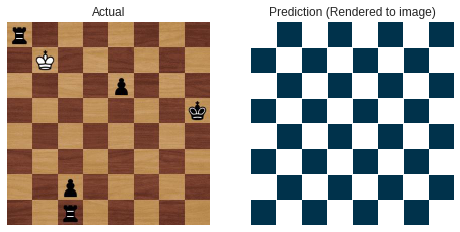


------------------------------------------------------------
Batch Number: 100
Example training point:
Actual: 6Q1-8-8-8-3k3r-8-8-K1R5
Guess: 6k1-8-8-8-3k3k-8-8-K1K5
Example Accuracy: 0.953125


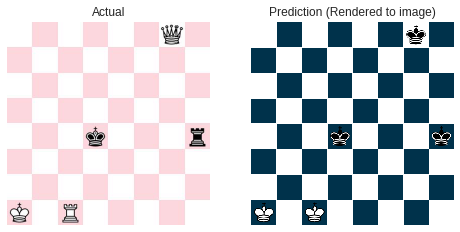


------------------------------------------------------------
Batch Number: 150
Example training point:
Actual: 1k6-8-8-7R-5r2-P7-8-K2Q4
Guess: 1p6-8-8-8-8-K7-8-K2R4
Example Accuracy: 0.921875


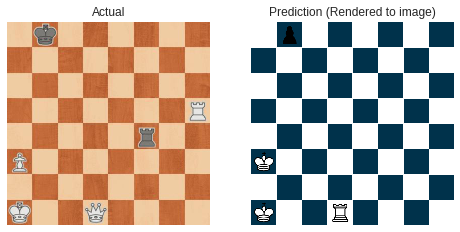


------------------------------------------------------------
Batch Number: 200
Example training point:
Actual: 8-p3K1n1-8-4q3-4k3-8-8-8
Guess: 8-r3K1k1-8-4k3-4k3-8-8-8
Example Accuracy: 0.953125


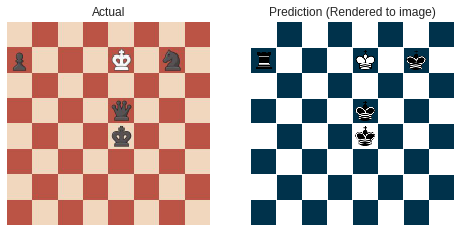


------------------------------------------------------------
Batch Number: 250
Example training point:
Actual: 8-8-3n4-3K4-8-3Br3-7k-R7
Guess: 8-8-3k4-3K4-8-3rb3-7k-R7
Example Accuracy: 0.953125


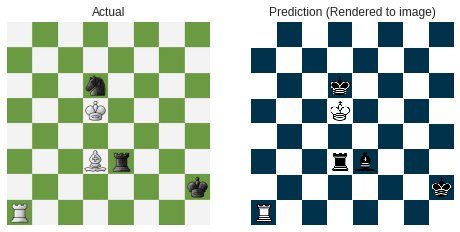


------------------------------------------------------------
Batch Number: 300
Example training point:
Actual: 3n3r-P7-8-K7-8-8-6k1-8
Guess: 3n3r-P7-8-K7-8-8-6k1-8
Example Accuracy: 1.0


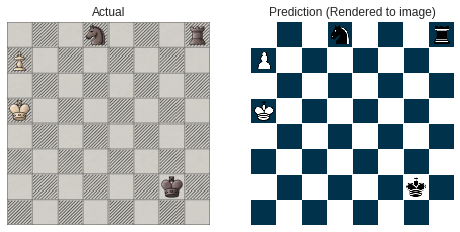


------------------------------------------------------------
Batch Number: 350
Example training point:
Actual: 8-K7-7r-6N1-5k2-8-8-2n3R1
Guess: 8-K7-7r-6N1-5k2-8-8-2n3R1
Example Accuracy: 1.0


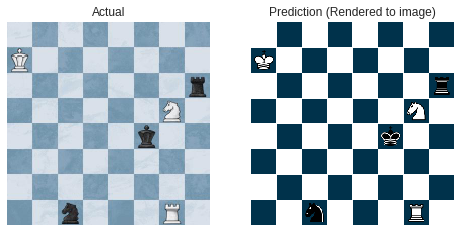


------------------------------------------------------------
Batch Number: 400
Example training point:
Actual: 8-8-K7-8-6Q1-2k5-P7-2R5
Guess: 8-8-K7-8-6n1-2k5-P7-2N5
Example Accuracy: 0.96875


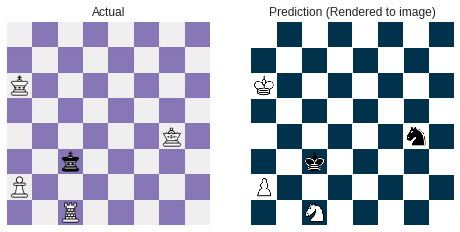


------------------------------------------------------------
Batch Number: 450
Example training point:
Actual: 5Q2-8-8-8-1B6-1K5R-3k4-8
Guess: 5Q2-8-8-8-1B6-1K5R-3k4-8
Example Accuracy: 1.0


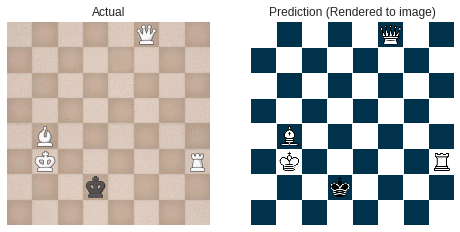


------------------------------------------------------------
Batch Number: 500
Example training point:
Actual: 8-8-8-6k1-8-pQ6-3K3p-1nn5
Guess: 8-8-8-6k1-8-pQ6-3K3p-1nn5
Example Accuracy: 1.0


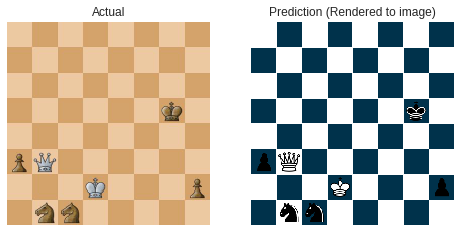


------------------------------------------------------------
Batch Number: 550
Example training point:
Actual: 8-3N1P2-K6k-8-1b6-8-8-8
Guess: 8-3N1P2-K6k-8-1b6-8-8-8
Example Accuracy: 1.0


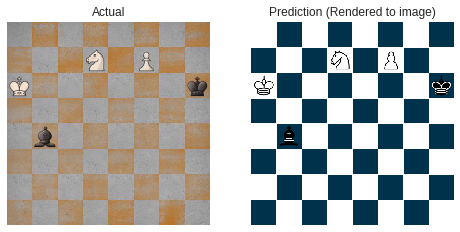


------------------------------------------------------------
Batch Number: 600
Example training point:
Actual: 2b4q-1K6-8-1Q6-6n1-6k1-r7-8
Guess: 2b4q-1K6-8-1Q6-6n1-6k1-r7-8
Example Accuracy: 1.0


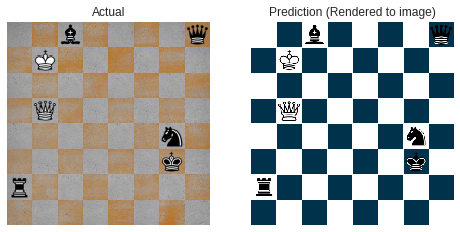


------------------------------------------------------------
Batch Number: 650
Example training point:
Actual: 4R2k-8-6P1-8-4r3-8-8-1K6
Guess: 4R2k-8-6P1-8-4r3-8-8-1K6
Example Accuracy: 1.0


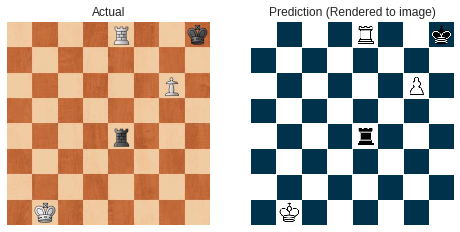


------------------------------------------------------------
Batch Number: 700
Example training point:
Actual: 8-6r1-R7-5K2-8-8-B2B4-6k1
Guess: 8-6r1-R7-5K2-8-8-B2B4-6k1
Example Accuracy: 1.0


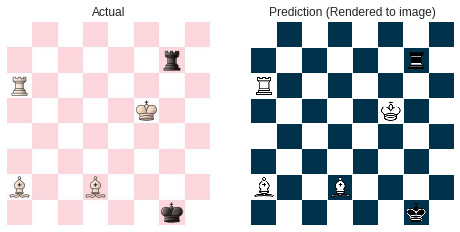


------------------------------------------------------------
Batch Number: 750
Example training point:
Actual: 5kn1-6n1-8-R1p5-3K4-8-8-6R1
Guess: 5kn1-6n1-8-R1p5-3K4-8-8-6R1
Example Accuracy: 1.0


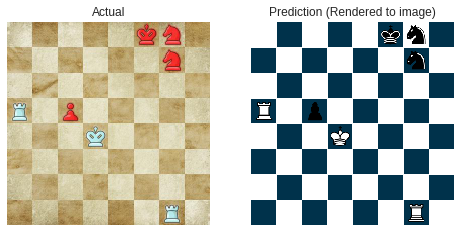

In [0]:
num_epochs = 1
log_freq=20


learning_rate = 0.0003
    
net = BiggerCNN(batch_size=BATCH_SIZE)

# print a summary of the net statistics
summary(net.to(device), (BATCH_SIZE*32, 3, 25, 25))

optimizer = optim.Adam(net.parameters(), lr=learning_rate)

log_dir = f'./logs/{net.name}_lr{learning_rate}'
criterion = nn.CrossEntropyLoss().to(device)

model = train_model(net,
                log_dir,
                train_loader,
                criterion,
                optimizer,
                num_epochs, 
                log_freq,
                print_guess=True)

# final_acc = test_model(model, criterion, test_loader)